# Offer amount prediction KC with classification

In [ ]:
!pip install ipython-sql

In [ ]:
#!pip install -U numpy

In [ ]:
#!python --version

In [ ]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [ ]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

%matplotlib inline


## Read Data

In [20]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = '../../redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']
connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [21]:
query="""
SELECT * FROM ml_prep.gauthier_offer_amount_prediction_dataset_kc WHERE channel_source IS NOT NULL ;
"""
df = pd.read_sql_query(query, con)
df.head(3)


origin flight_num dest departure_date                          request_id  \
0    AYT        216  TSE     2019-06-28  R2zmT8ALQl1vE6nGIC52ooMzcixRnyQNR0   
1    TSE        137  LED     2019-06-21  cOrF3Mnlzd9R3XoW1C5opEzjD0iKO48K9L   
2    ALA        859  SCO     2019-06-22  2A8GlHWxutZkANGgNcTkUuBD2Ck7URZvgR   

  upgrade_type      offer_status              created pax duration  ...  \
0     BUSINESS          TICKETED  2019-06-25 08:19:15   1      280  ...   
1     BUSINESS          TICKETED  2019-06-18 18:27:59   1      260  ...   
2     BUSINESS  CC_AUTH_DECLINED  2019-06-20 04:29:11   1      200  ...   

  offer_load_count   first_email_sent_time    last_email_sent_time  \
0                4 2019-06-16 05:00:25.130 2019-06-17 05:23:12.392   
1                2 2019-06-18 17:18:32.245 2019-06-18 17:18:32.245   
2               10 2019-06-20 04:00:10.291 2019-06-20 04:00:10.291   

   email_sent_count  first_email_opened_time  last_email_opened_time  \
0                 6      2019-06-18 12:21:52     2019-06-26 07:08:15   
1                 1      2019-06-18 18:20:36     2019-06-18 18:20:36   
2                 1      2019-06-20 04:25:41     2019-06-20 04:35:22   

   email_opened_count  first_email_clicked_time  last_email_clicked_time  \
0                  14                      None                     None   
1                   1                      None                     None   
2                   3                      None                     None   

  email_clicked_count  
0                   0  
1                   0  
2                   0  

[3 rows x 37 columns]

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5180 entries, 0 to 5179
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   origin                               5180 non-null   object        
 1   flight_num                           5180 non-null   object        
 2   dest                                 5180 non-null   object        
 3   departure_date                       5180 non-null   object        
 4   request_id                           5180 non-null   object        
 5   upgrade_type                         5180 non-null   object        
 6   offer_status                         5180 non-null   object        
 7   created                              5180 non-null   object        
 8   pax                                  5180 non-null   object        
 9   duration                             5180 non-null   object        
 10  point_of_sal

# Feature Engineering

In [23]:
#drop non relevant fields
df = df.drop(['request_id',  'pnr', 'offer_row_number','status',
                'offer_expiration_cutoff_local'       ,
                'offer_expiration_cutoff_server' ,     
                'offer_expiration_minutes'       ,     
                'offer_modification_cutoff_hours'   ,  
                'offer_modification_cutoff_local'   ,  
                'offer_modification_cutoff_server'    ,
                'on_hold'                  ,           
              'is_recent_offer','is_orphaned','customer_id','has_errors'  ], axis=1)



KeyError: "['pnr' 'status' 'offer_expiration_cutoff_local'\n 'offer_expiration_cutoff_server' 'offer_expiration_minutes'\n 'offer_modification_cutoff_hours' 'offer_modification_cutoff_local'\n 'offer_modification_cutoff_server' 'on_hold' 'is_recent_offer'\n 'is_orphaned' 'customer_id' 'has_errors'] not found in axis"

In [24]:
# compute some time-related features
# this takes some time
df['departure_hour'] = pd.to_datetime(df['departure_time']).apply(lambda x: x.hour)
df['departure_day_of_week']= pd.to_datetime(df['departure_time']).apply(lambda x: x.dayofweek)
df['departure_month']= pd.to_datetime(df['departure_time']).apply(lambda x: x.month)
df['submission_day_of_week']= pd.to_datetime(df['created']).apply(lambda x: x.dayofweek)
df['submission_hour']= pd.to_datetime(df['created']).apply(lambda x: x.hour)
df['submission_month']= pd.to_datetime(df['created']).apply(lambda x: x.month)
df['submission_year']= pd.to_datetime(df['created']).apply(lambda x: x.year)
df['origin_destination'] = df['origin']+ df['dest']
df["days_before_departure"] =(pd.to_datetime(df["departure_time"])-pd.to_datetime(df["created"]).dt.tz_localize(None)).apply(lambda x: x.days)
df["days_since_first_offer_load"] = (pd.to_datetime(df["created"]).dt.tz_localize(None) - pd.to_datetime(df["first_offer_load_time"]).dt.tz_localize(None)).apply(lambda x: x.days)
df["first_offer_load_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_offer_load_time"]).dt.tz_localize(None)).apply(lambda x: x.days)

df["first_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_sent"] = (pd.to_datetime(df["created"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_sent"] = (pd.to_datetime(df["created"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_opened"] = (pd.to_datetime(df["created"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_opened"] = (pd.to_datetime(df["created"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_clicked"] = (pd.to_datetime(df["created"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_clicked"] = (pd.to_datetime(df["created"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["days_between_first_last_email_sent"] = (pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_opened"] = (pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_clicked"] = (pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)



In [25]:
df.head(3)

origin flight_num dest departure_date                          request_id  \
0    AYT        216  TSE     2019-06-28  R2zmT8ALQl1vE6nGIC52ooMzcixRnyQNR0   
1    TSE        137  LED     2019-06-21  cOrF3Mnlzd9R3XoW1C5opEzjD0iKO48K9L   
2    ALA        859  SCO     2019-06-22  2A8GlHWxutZkANGgNcTkUuBD2Ck7URZvgR   

  upgrade_type      offer_status              created pax duration  ...  \
0     BUSINESS          TICKETED  2019-06-25 08:19:15   1      280  ...   
1     BUSINESS          TICKETED  2019-06-18 18:27:59   1      260  ...   
2     BUSINESS  CC_AUTH_DECLINED  2019-06-20 04:29:11   1      200  ...   

  last_email_opened_days_before_departure days_since_first_email_opened  \
0                                       2                             6   
1                                       3                             0   
2                                       2                             0   

   days_since_last_email_opened  first_email_clicked_days_before_departure  \
0                            -1                                          0   
1                             0                                          0   
2                            -1                                          0   

   last_email_clicked_days_before_departure  days_since_first_email_clicked  \
0                                         0                               0   
1                                         0                               0   
2                                         0                               0   

   days_since_last_email_clicked  days_between_first_last_email_sent  \
0                              0                                   1   
1                              0                                   0   
2                              0                                   0   

   days_between_first_last_email_opened days_between_first_last_email_clicked  
0                                     7                                     0  
1                                     0                                     0  
2                                     0                                     0  

[3 rows x 63 columns]

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5180 entries, 0 to 5179
Data columns (total 63 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   origin                                     5180 non-null   object        
 1   flight_num                                 5180 non-null   object        
 2   dest                                       5180 non-null   object        
 3   departure_date                             5180 non-null   object        
 4   request_id                                 5180 non-null   object        
 5   upgrade_type                               5180 non-null   object        
 6   offer_status                               5180 non-null   object        
 7   created                                    5180 non-null   object        
 8   pax                                        5180 non-null   object        
 9   duration           

# Feature Encoding

In [27]:
# for random forest, no need to one-hot-encode
def label_encode_categorical(df, columns):
    train_df_fact = df.copy()
    for column in columns:
        print('label encoding',column,'...')
        encoder = preprocessing.LabelEncoder()
        encoder.fit(train_df_fact[column])
        train_df_fact[column+'_encoded'] = encoder.transform(train_df_fact[column])
    return train_df_fact


In [28]:
# label-encode categories
df= label_encode_categorical(df,['upgrade_type','origin','dest','origin_destination','point_of_sale','channel_source','equipment'])

label encoding upgrade_type ...
label encoding origin ...
label encoding dest ...
label encoding origin_destination ...
label encoding point_of_sale ...
label encoding channel_source ...
label encoding equipment ...


# Label encoding

In [29]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df['offer_strength'])
df['offer_strength_encoded'] = label_encoder.transform(df['offer_strength'])

In [30]:
df["slider_min_usd"] = df["slider_min_usd"].fillna(0)
df["slider_max_usd"] = df["slider_max_usd"].fillna(0)
df["slider_starting_usd"] = df["slider_starting_usd"].fillna(0)

In [31]:
label_encoder.classes_

array(['HIGH', 'LOW', 'MEDIUM'], dtype=object)

In [32]:
df.head(3)

origin flight_num dest departure_date                          request_id  \
0    AYT        216  TSE     2019-06-28  R2zmT8ALQl1vE6nGIC52ooMzcixRnyQNR0   
1    TSE        137  LED     2019-06-21  cOrF3Mnlzd9R3XoW1C5opEzjD0iKO48K9L   
2    ALA        859  SCO     2019-06-22  2A8GlHWxutZkANGgNcTkUuBD2Ck7URZvgR   

  upgrade_type      offer_status              created pax duration  ...  \
0     BUSINESS          TICKETED  2019-06-25 08:19:15   1      280  ...   
1     BUSINESS          TICKETED  2019-06-18 18:27:59   1      260  ...   
2     BUSINESS  CC_AUTH_DECLINED  2019-06-20 04:29:11   1      200  ...   

  days_between_first_last_email_opened days_between_first_last_email_clicked  \
0                                    7                                     0   
1                                    0                                     0   
2                                    0                                     0   

   upgrade_type_encoded  origin_encoded  dest_encoded  \
0                     0               3            32   
1                     0              33            21   
2                     0               1            27   

   origin_destination_encoded  point_of_sale_encoded  channel_source_encoded  \
0                          29                      0                      20   
1                          97                      0                      19   
2                          20                      0                      19   

   equipment_encoded offer_strength_encoded  
0                  3                      1  
1                  2                      1  
2                  2                      0  

[3 rows x 71 columns]

In [33]:
columns_for_training= [
                       # departure time
                       'departure_hour',
                       'departure_day_of_week',
                       'departure_month',
                       # event time
                       'submission_hour',
                       'submission_day_of_week',
                       'submission_month',
                       'submission_year',
                       'days_before_departure',
                       # route
                       'origin_encoded', 
                       'dest_encoded',
                       'origin_destination_encoded',
                       'duration', 
                       #'distance', 
                       # the rest
                       'channel_source_encoded',
                       'pax',
                       'point_of_sale_encoded',
                       'equipment_encoded',
                       'upgrade_type_encoded',
                       # partner
                       # since we just have KC ¯\_(ツ)_/¯
                       #'carrier_encoded',
                       # slider
                        'slider_max_usd',        
                        'slider_min_usd',        
                        'slider_starting_usd',  
                        'starting_slider_strength_percentage',
                        'slider_min_max_ratio',
                        'slider_range_usd',
                       # offer loads
                        'first_offer_load_days_before_departure',
                        'days_since_first_offer_load',
                        'offer_load_count',
                        # email 
                        'first_email_sent_days_before_departure',
                        'last_email_sent_days_before_departure',
                        'days_since_first_email_sent',
                        'days_since_last_email_sent',
                        'first_email_opened_days_before_departure',
                        'last_email_opened_days_before_departure',
                        'days_since_first_email_opened',
                        'days_since_last_email_opened',
                        'first_email_clicked_days_before_departure',
                        'last_email_clicked_days_before_departure',
                        'days_since_first_email_clicked',
                        'days_since_last_email_clicked',
                        'days_between_first_last_email_sent',
                        'days_between_first_last_email_opened',
                        'days_between_first_last_email_clicked',
                        'email_sent_count',
                        'email_opened_count',
                        'email_clicked_count',
                       # target
                        'offer_strength_encoded',
                      ]

df = df[columns_for_training]

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5180 entries, 0 to 5179
Data columns (total 45 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   departure_hour                             5180 non-null   int64  
 1   departure_day_of_week                      5180 non-null   int64  
 2   departure_month                            5180 non-null   int64  
 3   submission_hour                            5180 non-null   int64  
 4   submission_day_of_week                     5180 non-null   int64  
 5   submission_month                           5180 non-null   int64  
 6   submission_year                            5180 non-null   int64  
 7   days_before_departure                      5180 non-null   int64  
 8   origin_encoded                             5180 non-null   int64  
 9   dest_encoded                               5180 non-null   int64  
 10  origin_destination_encod

In [35]:
df.head(4)

departure_hour  departure_day_of_week  departure_month  submission_hour  \
0              11                      4                6                8   
1              20                      4                6               18   
2              21                      5                6                4   
3              22                      5                6                5   

   submission_day_of_week  submission_month  submission_year  \
0                       1                 6             2019   
1                       1                 6             2019   
2                       3                 6             2019   
3                       0                 6             2019   

   days_before_departure  origin_encoded  dest_encoded  ...  \
0                      3               3            32  ...   
1                      3              33            21  ...   
2                      2               1            27  ...   
3                      5              17            32  ...   

   last_email_clicked_days_before_departure days_since_first_email_clicked  \
0                                         0                              0   
1                                         0                              0   
2                                         0                              0   
3                                         0                              0   

   days_since_last_email_clicked days_between_first_last_email_sent  \
0                              0                                  1   
1                              0                                  0   
2                              0                                  0   
3                              0                                  3   

   days_between_first_last_email_opened  \
0                                     7   
1                                     0   
2                                     0   
3                                     2   

   days_between_first_last_email_clicked  email_sent_count  \
0                                      0                 6   
1                                      0                 1   
2                                      0                 1   
3                                      0                 4   

   email_opened_count  email_clicked_count  offer_strength_encoded  
0                  14                    0                       1  
1                   1                    0                       1  
2                   3                    0                       0  
3                   8                    0                       1  

[4 rows x 45 columns]

# Model Training & Evaluation

In [36]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [37]:
def train_and_evaluate(df_to_train, plot_learning_curves=False, limit=None, split_on_time=False):
    # X-validation
    from sklearn.preprocessing import label_binarize
    from sklearn.multiclass import OneVsRestClassifier
    
    if limit is not None:
        #pick them randomly
        df_to_train = df_to_train.sample(n=limit)

    random_forest =  OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
    X = df_to_train.drop("offer_strength_encoded", axis=1)
    y_raw = df_to_train["offer_strength_encoded"]
    
    y = label_binarize(y_raw, classes=[0, 1, 2])

    n_classes = y.shape[1]
    
    if split_on_time:
        X_train = X[X["submission_year"] == 2019 ].drop("submission_year", axis=1)
        y_train = y[X["submission_year"] == 2019]
        X_test = X[X["submission_year"] == 2020].drop("submission_year", axis=1)
        y_test = y[X["submission_year"] == 2020]
        pass
    else:
        X = X.drop("submission_year", axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)


    # train
    print('training on', str(len(X_train)), 'rows...')
    random_forest.fit(X_train, y_train)
    print('training is done!')
    print('testing on', str(len(X_test)), 'rows...')

    # predict
    y_test_proba = random_forest.predict_proba(X_test)
    y_test_predict = random_forest.predict(X_test)

    #print('y_test_proba',y_test_proba)
    #print('y_test_predict',y_test_predict)
    # evaluation metrics

    roc_auc = dict()
    
    colors = ['red', 'blue', 'green']
    
    plt.figure(figsize=(16,9))
    for i,color in zip(range(n_classes),colors):
        fpr, tpr, _ = metrics.roc_curve(y_test[:, i], y_test_proba[:, i])
        plt.title('ROC')
        plt.plot([0, 1], [0,1], 'k--')
        roc_auc_for_one_class=metrics.auc(fpr, tpr)
        roc_auc[i] = roc_auc_for_one_class
        plt.plot(fpr, tpr,marker='.',color=color, label='{0} (AUC = {1:0.2f})'.format(label_encoder.classes_[i], roc_auc_for_one_class))
        plt.legend(loc="center right")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    roc_auc = metrics.roc_auc_score(y_test,y_test_proba,multi_class="ovr")
    
    print('global roc_auc',roc_auc)
    
    
    plt.figure(figsize=(16,9))
    for i,color in zip(range(n_classes),colors):
        precisions, recalls, thresholds = metrics.precision_recall_curve(y_test[:, i], y_test_proba[:, i])
        plt.title('Precision-Recall')
        roc_pr_for_one_class=metrics.auc(recalls, precisions)
        plt.plot(recalls, precisions,marker='.',color=color, label='{0} (AUC = {1:0.2f})'.format(label_encoder.classes_[i], roc_pr_for_one_class))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="center right")
        # proportion of positive examples
        #no_skill = len(y[y==1]) / len(y)
        #plt.plot([0, 1], [no_skill, no_skill], linestyle='--')

    #print('precisions',precisions)
    #print('recalls',recalls)
    #print('thresholds',thresholds)

    precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test,y_test_predict)

    for i in range(n_classes):
        print('#### CLASS',label_encoder.classes_[i],'####')
        print('precision', precision[i])
        print('recall', recall[i])
        print('f1', f1[i])
        print('support', support[i])

    cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_test_predict.argmax(axis=1))
    print_confusion_matrix(cm, label_encoder.classes_)
    
    
    for i in range(n_classes):
        features = X_train.columns
        importances = random_forest.estimators_[i].feature_importances_
        indices = np.argsort(importances)[::-1]
        print('# KC offer strength prediction. Feature importance for',label_encoder.classes_[i])
        for feature,importance in zip(features[indices],importances[indices]):
            print(feature+','+str(importance))
    
        # Plot the impurity-based feature importances of the forest
        plt.figure(figsize=(16,9))
        plt.title('Feature Importances for class '+ label_encoder.classes_[i])
        plt.bar(range(len(indices)), importances[indices], color='b', align='center')   
        plt.xticks(range(X_train.shape[1]), features[indices],rotation=90)
    
    if plot_learning_curves:
        scoring = 'roc_auc'
        print('Computing Learning curves...')
        train_sizes, train_scores, test_scores = \
                learning_curve(random_forest, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring=scoring, cv=2)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(16,9))
        # Plot learning curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.xlabel("Training examples")
        plt.ylabel(scoring)
        plt.title("Learning Curves")


        print(train_sizes)
        print(train_scores)
        print(test_scores)

In [ ]:
# run with a lot of data
train_and_evaluate(df,plot_learning_curves=False)

training on 4220 rows...
training is done!
testing on 960 rows...
global roc_auc 0.6474210209072898


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### CLASS HIGH ####
precision 0.0
recall 0.0
f1 0.0
support 12
#### CLASS LOW ####
precision 0.9205851619644723
recall 0.9977349943374858
f1 0.9576086956521739
support 883
#### CLASS MEDIUM ####
precision 0.0
recall 0.0
f1 0.0
support 65
# KC offer strength prediction. Feature importance for HIGH
slider_min_usd,0.05723529165033758
slider_starting_usd,0.05637332788330052
slider_max_usd,0.05148182247729296
slider_min_max_ratio,0.051402952122215184
starting_slider_strength_percentage,0.05013998228943016
slider_range_usd,0.04723349561856105
submission_hour,0.045625220542573834
days_before_departure,0.04376347654483877
departure_hour,0.03781360622153238
first_offer_load_days_before_departure,0.037674737618736305
offer_load_count,0.03759509453802103
duration,0.03474321243763651
origin_destination_encoded,0.03403193058013828
submission_month,0.030381331867712184
departure_month,0.02598875293203229
channel_source_encoded,0.025955111554128538
departure_day_of_week,0.025763482093765368
last_ema

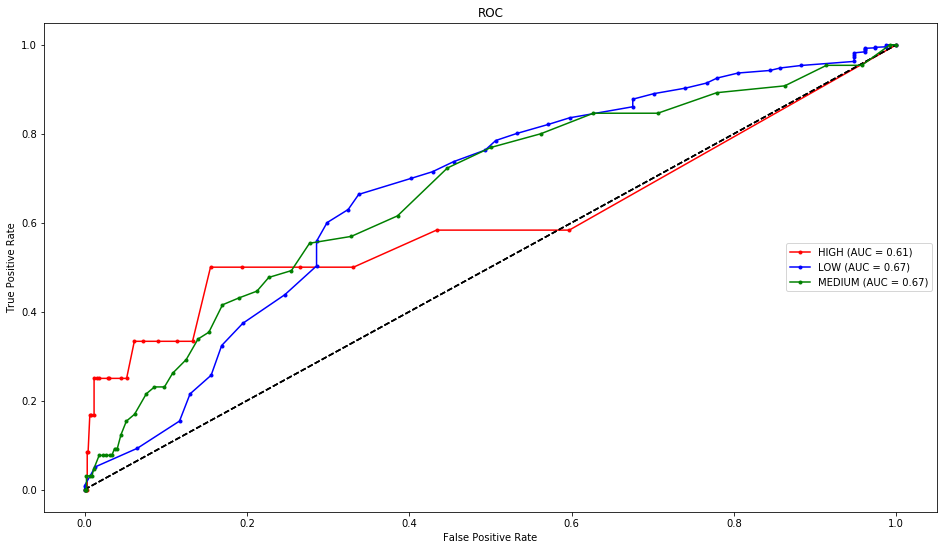

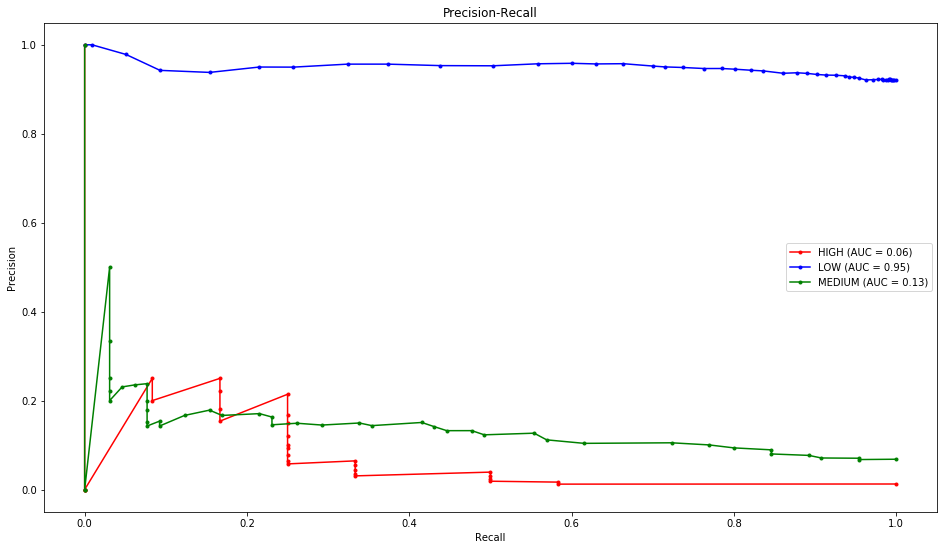

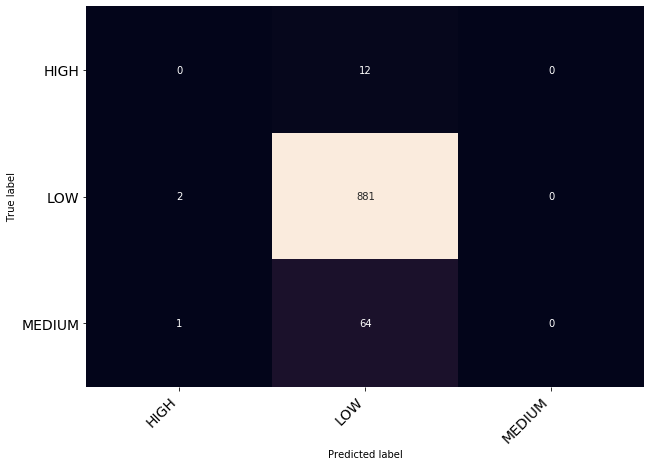

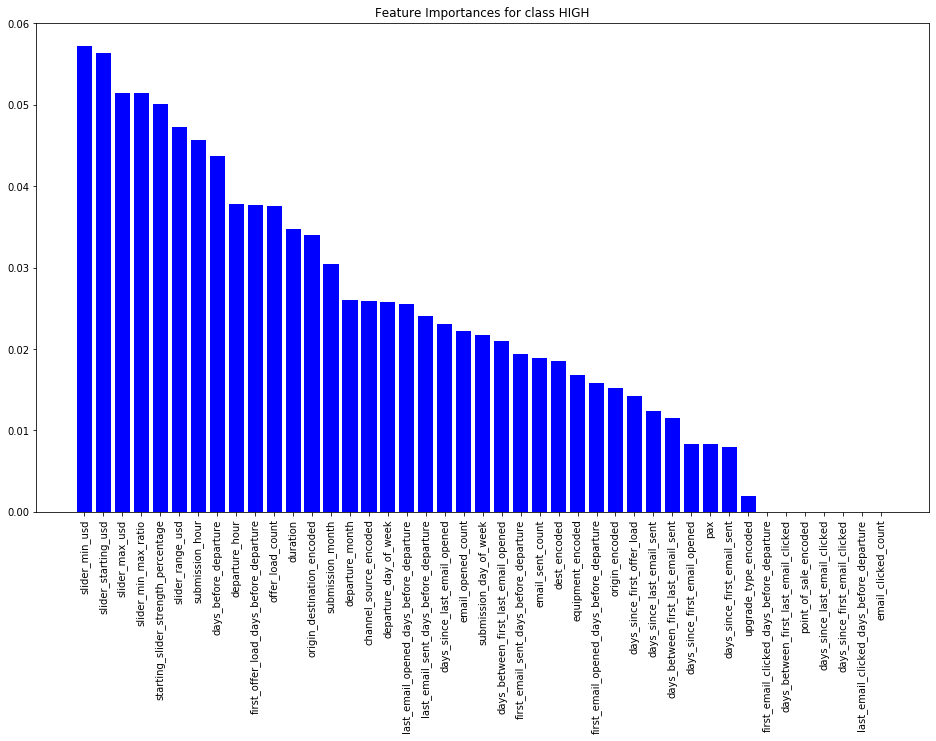

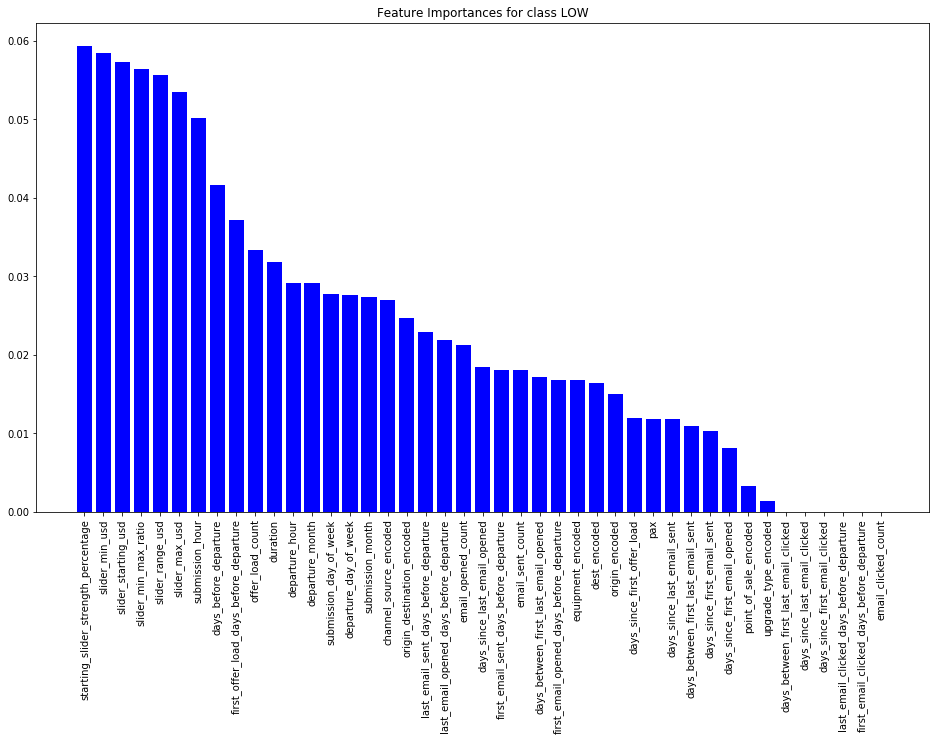

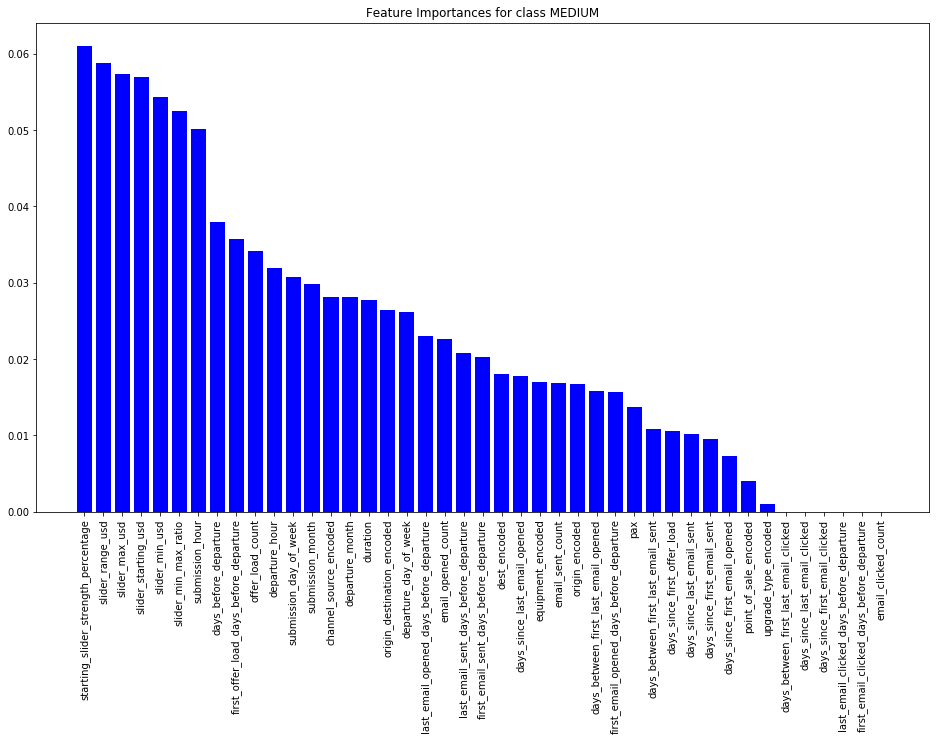

In [38]:
# run with a lot of data split on time (year 2019 vs 2020)
train_and_evaluate(df,plot_learning_curves=False, split_on_time=True)